#### Data Source - Issue date : 2017/06/21

In [8]:
import numpy as np
import pandas as pd
import math
from scipy import interpolate
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import dill

#### Settings - 1

In [2]:
# Simulation Settings
num_paths = 2000
yr_length = 30
days_per_yr = 360
timesteps = days_per_yr * yr_length
dt = 1 / days_per_yr # Time Step 

#### Credit Spread Adjustment for Lambda Estimation

In [3]:
# Corporate Bond Reference Yield Curve 
# https://www.tpex.org.tw/web/bond/tradeinfo/govbond/GovBondDaily_02.php?l=zh-tw
COCurve = pd.read_excel('.\data_source\COCurve.20170621-C.xls', sheet_name='COCurve')
COC_df = COCurve.rename(columns=COCurve.iloc[1]).drop(COCurve.index[[0, 1, 6]]).set_index('到期年限')
COC_df.index.rename(name='Rated', inplace=True)
COC_twAA = COC_df.loc['twAA']
print(COC_twAA)

1個月    0.005173
3個月     0.00572
6個月    0.006273
1年     0.007169
2年     0.008066
3年     0.009218
4年      0.00996
5年     0.010702
6年     0.011699
7年     0.012696
8年      0.01338
9年     0.014065
10年    0.014749
Name: twAA, dtype: object


#### Government Bond Yield Curve

In [4]:
# Government Bond Yield Curve
# https://www.tpex.org.tw/web/bond/tradeinfo/govbond/GovBondDaily_02.php?l=zh-tw
YCurve = pd.read_excel('.\data_source\Curve.20170621-C.xls', sheet_name='含息殖利率曲線')
YC_df = YCurve.set_index('Tenor').drop(['Bond Code'], axis=1).dropna()
YC_tw = YC_df.iloc[:,0]/100
print(YC_tw)

Tenor
2年(Year)     0.004800
5年(Year)     0.007596
10年(Year)    0.010750
20年(Year)    0.017000
30年(Year)    0.018400
Name: 2017-06-21 00:00:00, dtype: float64


In [5]:
Maturity_Selected = ['1年', '2年', '3年', '5年', '10年']
COC_MT = [1, 2, 3, 5, 10] # in year (select the maturity we need)

In [6]:
### Cubic Spline Interpolation for YC_tw
def Interpolation_YC(x):
    x_points = [ 2, 5, 10, 20, 30 ]
    y_points = list(YC_tw)
    tck = interpolate.splrep(x_points, y_points)
    return interpolate.splev(x, tck)

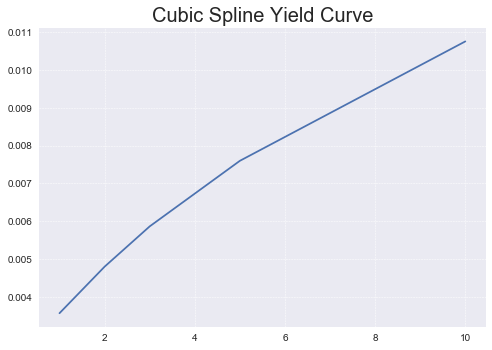

In [9]:
ix = 0
YC_tw_value = np.zeros(len(COC_MT))
time_len = np.zeros(len(COC_MT))

for x in COC_MT :
    YC_tw_value[ix], time_len[ix] = Interpolation_YC(x), x
    ix += 1

plt.title('Cubic Spline Yield Curve', size=20 )
plt.plot(time_len, YC_tw_value)
plt.grid(linestyle='--', linewidth=0.5)

In [10]:
# Table of Credit Spread
COC_value = COC_twAA.loc[Maturity_Selected]
Cr_Spread = list(COC_value) - YC_tw_value
df_Cr_Spread = pd.DataFrame(Cr_Spread, columns=['Credit Spread'])
df_Cr_Spread['Maturity'] = list(Maturity_Selected)
df_Cr_Spread.set_index('Maturity')

,Credit Spread
Maturity,
1年,0.003598
2年,0.003266
3年,0.003354
5年,0.003106
10年,0.003999


In [12]:
### LGD=50%  
### Using Mean Square Error minimization for Lambda Estimation
LGD = 0.5
init_lambda = 0.05
PD = ( 1-np.exp(-np.multiply(Cr_Spread, COC_MT)) ) / LGD   
print('Default Probablity List :', PD)

Default Probablity List : [0.0071826  0.01302143 0.02002225 0.03082006 0.07840191]


In [13]:
def loss_func(lamb) : 
    E_PD = list( (1 - np.exp(-lamb*i)) for i in COC_MT)
    MSE = ( np.array(PD) - np.array(E_PD) )**2
    return np.sum(MSE)

In [14]:
result = minimize_scalar(loss_func)
est_lambda = result.x
print('Estimated Lambda :', est_lambda)
print('Estimated Default Probability:', 1 - np.exp(-float(est_lambda)))

Estimated Lambda : 0.0076439328623178
Estimated Default Probability: 0.007614792304278084


#### Settings - 2

In [15]:
# Bond Settings
Face_Val = 1000
Redempt_Price = 1000 
coupon = [ 0, Face_Val*0.0345, Face_Val*0.0445] 
dr_prob = 1 - np.exp(-float(est_lambda)*dt)  # Default LAMBDA
reco_rate = 0.5 # Recovery Rate

#### Hull White Monte Carlo

In [16]:
YCDF = pd.DataFrame(YC_tw)
YCDF.columns = ['Interest Rate']
YCDF['MT_dt'] = [ 2, 5, 10, 20, 30 ]

In [17]:
YCDF

,Interest Rate,MT_dt
Tenor,,
2年(Year),0.004800,2
5年(Year),0.007596,5
10年(Year),0.010750,10
20年(Year),0.017000,20
30年(Year),0.018400,30


In [18]:
def YTM_fit( YTM, days_df, reversion_speed, volatility, length, days_count ) : 
    # Create the modified input X 
    coeff = np.polyfit( days_df, YTM, 3 ) 
    ## Make Prediction
    Y = np.zeros(length * days_count)
    
    for i, x in zip( list(range(days_count*length)), 
                    [ t/days_count for t in range(1, days_count*length+1)] ) :  
        zero = coeff[3] * reversion_speed
        first = 2 * coeff[2] * (1 + reversion_speed * x)  
        second = 3 * coeff[1] * (2 + reversion_speed * x) * x
        third = 4 * coeff[0] * (3 + reversion_speed * x) * x**2
        epsilon = volatility**2 / ( 2 * reversion_speed ) * (1 - np.exp(-reversion_speed * x)) 
        Y[i] = zero + first + second + third + epsilon                 
    
    return Y , coeff

In [19]:
def MC_Hull( I0, K, theta, sigma, steps ) :
    # np.random.seed(seed)
    dt = 1 / steps    
    rates = [ I0 ]
    for i in range(steps):
        dr = (theta[i] - K*rates[-1])*dt + sigma*np.sqrt(dt)*np.random.normal()
        rates.append(rates[-1] + dr)
    return  rates

In [20]:
## Initial Setting for Rate Simulation
Init_Rate = 0.026 # 基準利率
rv_spd = 0.05
vol = 0.025

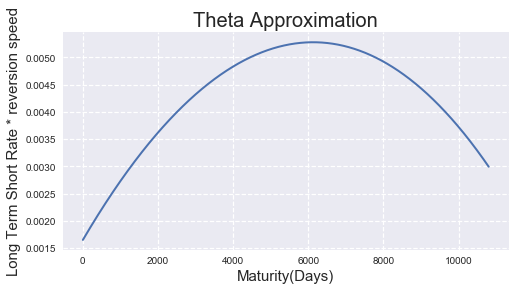

In [21]:
THETA , coef = YTM_fit( YCDF['Interest Rate'], YCDF['MT_dt'], rv_spd, vol, yr_length, days_per_yr )
plt.figure(figsize=(8, 4))
plt.title('Theta Approximation', size=20)
plt.xlabel('Maturity(Days)',size=15)
plt.ylabel('Long Term Short Rate * reversion speed',size=15)
plt.grid(linestyle='--', linewidth=1.2)
plt.plot(THETA, linewidth=2)

In [22]:
paths = MC_Hull( I0=Init_Rate, K=rv_spd, theta=THETA, sigma=vol, steps=timesteps)
for i in range(num_paths-1):
    paths = np.vstack(( paths, MC_Hull( I0=Init_Rate, K=rv_spd, theta=THETA, sigma=vol,
                                        steps=timesteps) ))
print('Interest Rate Path Shape : ', paths.shape)

Interest Rate Path Shape :  (2000, 10801)


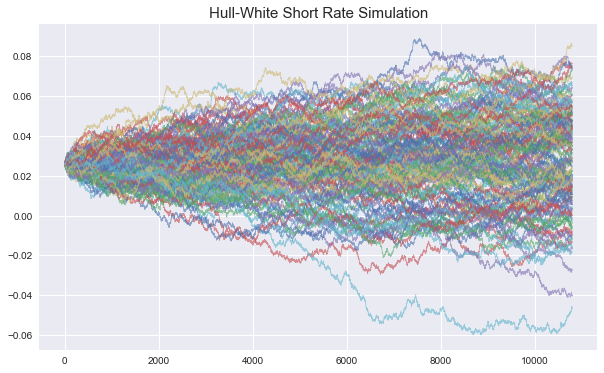

In [23]:
plt.figure(figsize=(10, 6))
plt.title("Hull-White Short Rate Simulation", size=15)
for i in range(150):
    plt.plot( paths[i, :], lw=0.8, alpha=0.6)
plt.show()

#### Rule Matrix

In [24]:
# Only for testing 
call_or_not = np.zeros(timesteps)
for i in range(int(days_per_yr), timesteps, days_per_yr):
    if i < days_per_yr*10 : 
        call_or_not[i] = 0
    else : 
        call_or_not[i] = 1

cp_or_not = np.zeros(timesteps)
for i in range(int(days_per_yr), timesteps, days_per_yr):
    cp_or_not[i] = 1

decision = np.concatenate((call_or_not, cp_or_not)).reshape(2, timesteps)
temp_path = np.delete(paths, 0, axis=1) # interest rate path without initial value

#### Implementing LSM

In [25]:
def discount_func( prev_val, rt, dr_prob, rc, redem, cp, s ) :
    value = cp + np.exp( -(rt + s)*dt ) * ( (1 - dr_prob)*prev_val + dr_prob*rc*redem )
    return value

In [26]:
def full_disc(lq_sprd):
    #  Create Empty Matrix for Present Value 
    V = np.zeros((num_paths, timesteps)) 
    ###################################################################################################
    value = Face_Val
    counts = 0

    for t in range(timesteps-1, -1, -1) :
        # callable : no /  coupon : no
        if list(decision[:, t]) == [0.0, 0.0] :  
            value = discount_func(value, temp_path[:, t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[0], s=lq_sprd )
            V[:, t] = value 

        # callable : no /  coupon : yes
        elif list(decision[:, t]) == [0.0, 1.0] : 
            value = discount_func( value, temp_path[:,t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[1], s=lq_sprd )
            V[:, t] = value 

        # callable : yes /  coupon : no
        elif list(decision[:, t]) == [1.0, 0.0] : 
            value = discount_func( value, temp_path[:,t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[0], s=lq_sprd )
            V[:, t] = value
            itm = np.greater( V[:, t], Redempt_Price)
            V_itm = np.compress( itm == 1, V[:, t] )
            r_itm = np.compress( itm == 1, temp_path[:, t] )
            if len(r_itm) == 0 : 
                continue
            else : 
                rg = np.polyfit( r_itm, np.log(V_itm), 2 )
                H = np.exp( np.polyval(rg, r_itm ) )
                V[itm == True][:, t] = np.where( H > Redempt_Price, Redempt_Price, H )
                counts += 1

        # callable : yes /  coupon : yes
        else :                         
            value = discount_func(value, temp_path[:, t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[2], s=lq_sprd )
            V[:, t] = value
            itm = np.greater(V[:, t], Redempt_Price)
            V_itm = np.compress( itm == 1, V[:, t] )
            r_itm = np.compress( itm == 1, temp_path[:, t] )
            if len(r_itm) == 0 : 
                continue
            else :            
                rg = np.polyfit( r_itm, np.log(V_itm), 2 )
                H = np.exp(np.polyval( rg, r_itm ) )
                V[itm == True][:, t] = np.where( H > Redempt_Price, coupon[2]+Redempt_Price, H )
                counts += 1
    result = {'V-Matrix':V, 'Counts':counts}
    return result

In [27]:
def illustrate(result):
    print('Numbers of Call :', result['Counts'])
    ### Path Examination
    plt.figure(figsize=(12, 6))
    plt.title('Discount Path', size=15)
    for i in range(100):    
        plt.plot(result['V-Matrix'][i,:])
    print('The Mean Price of LSM : ', np.mean( result['V-Matrix'][:,0]) )
    print('The Median Price of LSM : ', np.median( result['V-Matrix'][:,0]) )
    print('The S.D of Price with LSM : ', np.std( result['V-Matrix'][:,0]))

    plt.figure(figsize=(12, 6))
    plt.title('Bond Price Distribution Plot', size=15)
    plt.xlabel('Price')
    sns.distplot(result['V-Matrix'][:,0], hist=True, kde=False, 
                 bins=50, color = 'blue',
                 hist_kws={'edgecolor':'red'})

Numbers of Call : 20
The Mean Price of LSM :  1196.1900645887997
The Median Price of LSM :  1150.3696285400993
The S.D of Price with LSM :  283.8936633218434


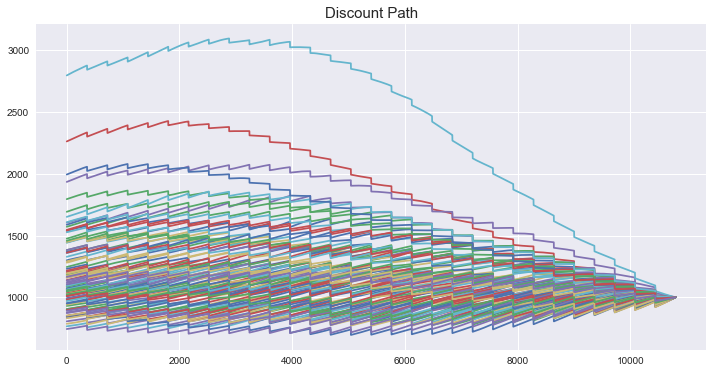

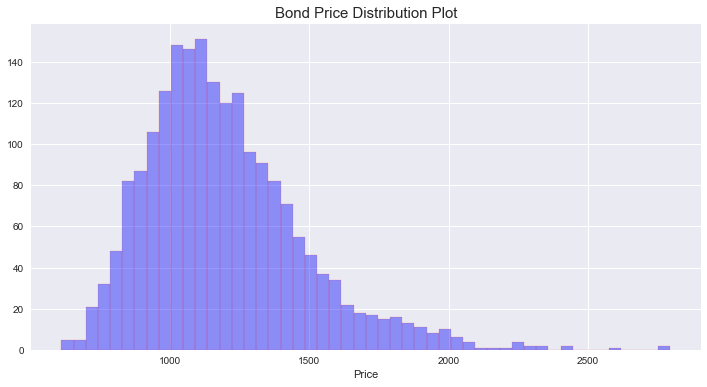

In [28]:
illustrate(full_disc(lq_sprd=0.0))

#### Solution For Liquidity Factor

In [29]:
def full_disc_solve(lq_sprd):
    #  Create Empty Matrix for Present Value 
    V = np.zeros((num_paths, timesteps)) 
    ###################################################################################################
    value = Face_Val
    counts = 0

    for t in range(timesteps-1, -1, -1) :
        # callable : no /  coupon : no
        if list(decision[:, t]) == [0.0, 0.0] :  
            value = discount_func(value, temp_path[:, t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[0], s=lq_sprd )
            V[:, t] = value 

        # callable : no /  coupon : yes
        elif list(decision[:, t]) == [0.0, 1.0] : 
            value = discount_func( value, temp_path[:,t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[1], s=lq_sprd )
            V[:, t] = value 

        # callable : yes /  coupon : no
        elif list(decision[:, t]) == [1.0, 0.0] : 
            value = discount_func( value, temp_path[:,t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[0], s=lq_sprd )
            V[:, t] = value
            itm = np.greater( V[:, t], Redempt_Price)
            V_itm = np.compress( itm == 1, V[:, t] )
            r_itm = np.compress( itm == 1, temp_path[:, t] )
            if len(r_itm) == 0 : 
                continue
            else : 
                rg = np.polyfit( r_itm, np.log(V_itm), 2 )
                H = np.exp( np.polyval(rg, r_itm ) )
                V[itm == True][:, t] = np.where( H > Redempt_Price, Redempt_Price, H )
        
        # callable : yes /  coupon : yes
        else :                         
            value = discount_func(value, temp_path[:, t], dr_prob, reco_rate, 
                                  Redempt_Price, coupon[2], s=lq_sprd )
            V[:, t] = value
            itm = np.greater(V[:, t], Redempt_Price)
            V_itm = np.compress( itm == 1, V[:, t] )
            r_itm = np.compress( itm == 1, temp_path[:, t] )
            if len(r_itm) == 0 : 
                continue
            else :            
                rg = np.polyfit( r_itm, np.log(V_itm), 2 )
                H = np.exp(np.polyval( rg, r_itm ) )
                V[itm == True][:, t] = np.where( H > Redempt_Price, coupon[2]+Redempt_Price, H )
    
    return np.mean(V[:,0])-1000.0

In [30]:
init_lq_sprd = 0.001
est_lq_sprd = float(fsolve(full_disc_solve, init_lq_sprd))
print('Estimated Liquidity Factor :', est_lq_sprd)

Estimated Liquidity Factor : 0.009803059685330219


Numbers of Call : 20
The Mean Price of LSM :  1000.0
The Median Price of LSM :  965.7576484422668
The S.D of Price with LSM :  220.06048238542206


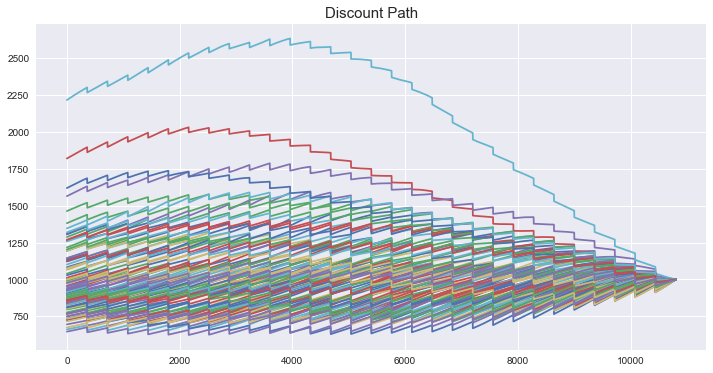

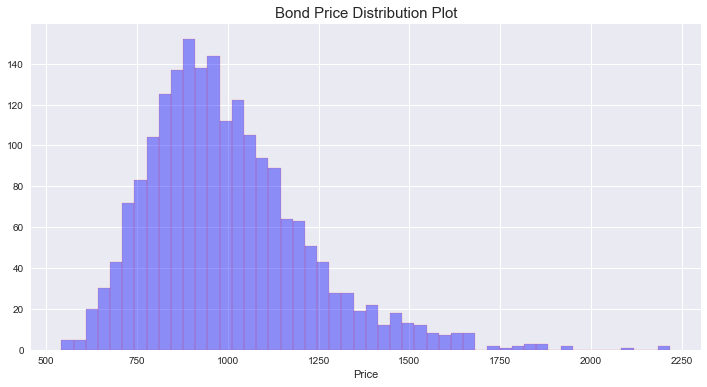

In [31]:
illustrate(full_disc(est_lq_sprd))

#### Save Session

In [32]:
filename = 'globalsave.pkl'
dill.dump_session(filename)

#### Load Session 

In [33]:
# filename = 'globalsave.pkl'
# dill.load_session(filename)